In [2]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math

from hera_sim import foregrounds, noise, sigchain, rfi

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [3]:
def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3

dataset = np.load('dataset.npy')
labels = np.load('labels.npy')

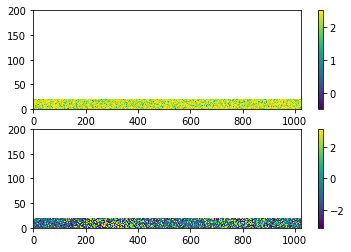

In [4]:
# initialize test point
test_pt = dataset[7]
plot_one_vis(test_pt, 200)

# test_pt = np.expand_dims(test_pt, axis=0) # add dimension of 1 at front

- ReLu activation function: for x, it returns max(0, x)
- He weight initialization is a good option: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

In [7]:
faulty_predictions = []

for i in range(10):
	# configure the dataset
	X, y = dataset, labels
	X = X.astype('float32')

	# split into train and test datasets
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # train_test_split does a random split
	# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
	n_features = (X_train.shape[1], X_train.shape[2])
	# print(n_features)

	# define model
	model = tf.keras.Sequential()
	model.add(layers.Flatten(input_shape=n_features))
	model.add(layers.Dense(25, activation='relu', kernel_initializer='he_normal'))
	model.add(layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
	model.add(layers.Dense(1, activation='sigmoid'))

	# compile the model
	model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

	# fit the model
	model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

	# evaluate the model
	loss, acc = model.evaluate(X_test, y_test, verbose=0)
	print('Test Accuracy: %.3f' % acc)

	# make a prediction
	# yhat = model.predict([test_pt]) # predict one point
	# print('Predicted: %.3f' % yhat)

	predictions = model.predict_classes(X)
	predictions = predictions.flatten()

	for i in range(len(predictions)):
		if predictions[i] != y[i]:
			faulty_predictions.append(i)

print(faulty_predictions)

model.summary()

Test Accuracy: 0.987
Test Accuracy: 0.990
Test Accuracy: 0.990
Test Accuracy: 0.990
Test Accuracy: 0.985
Test Accuracy: 0.987
Test Accuracy: 0.972
Test Accuracy: 0.990
Test Accuracy: 0.985
Test Accuracy: 0.990
[45, 95, 158, 173, 183, 2, 20, 54, 60, 185, 10, 42, 118, 739, 2, 116, 178, 543, 546, 547, 946, 947, 19, 48, 63, 81, 118, 547, 51, 58, 66, 174, 948, 45, 57, 69, 70, 93, 94, 96, 184, 750, 943, 950, 951, 958, 59, 121, 172, 546, 21, 85, 103, 148, 163, 947, 13, 57, 86, 173]
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 20480)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 25)                512025    
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 208       
___________________________________

60


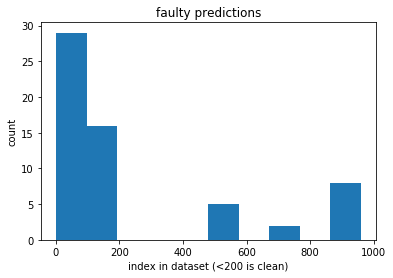

In [14]:
print(len(faulty_predictions))

plt.hist(faulty_predictions)
plt.xlabel("index in dataset (<200 is clean)")
plt.ylabel("count")
plt.title("faulty predictions")
plt.show()


### Visualize faulty predictions

In [28]:
print(len(faulty_predictions))

93


5


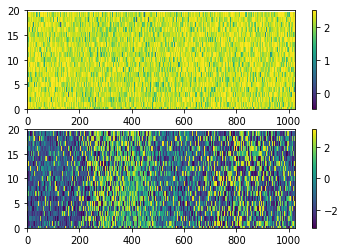

16


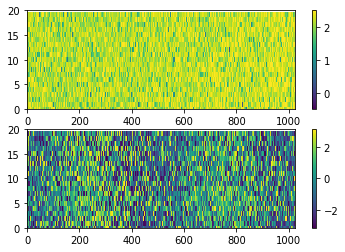

32


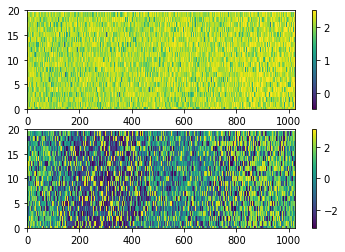

49


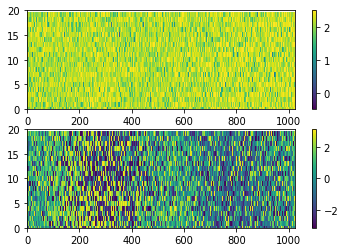

65


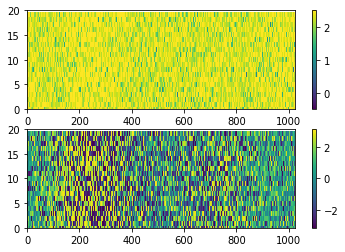

67


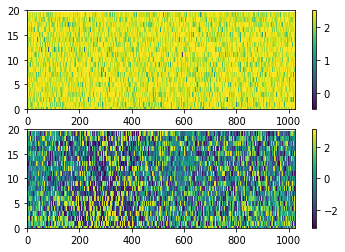

68


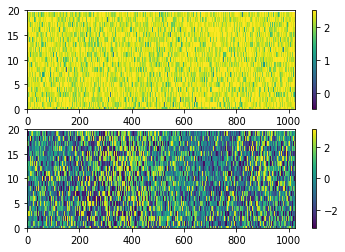

89


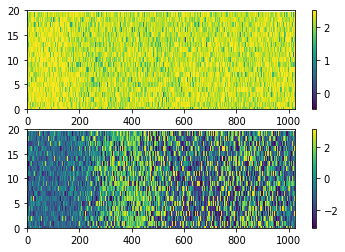

91


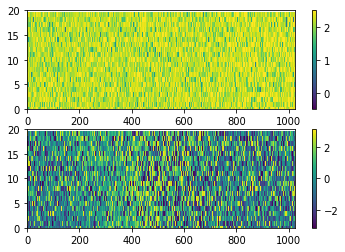

92


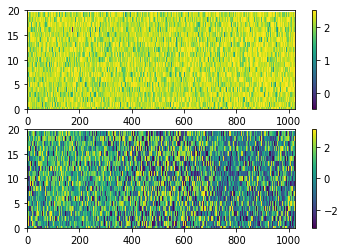

95


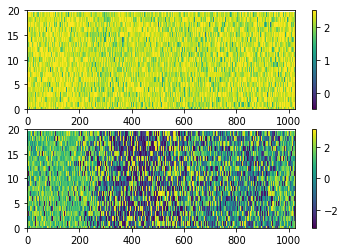

107


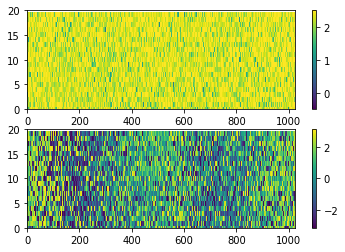

116


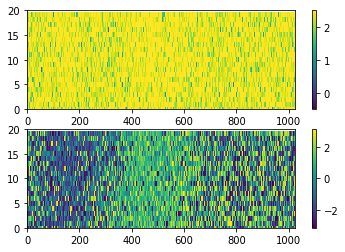

119


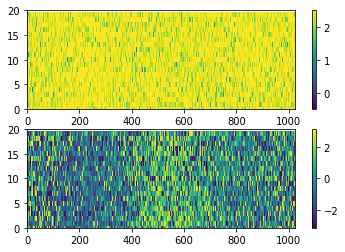

120


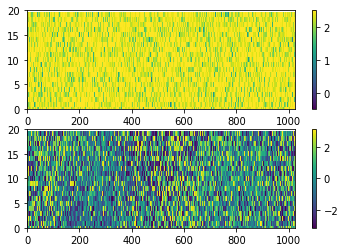

122


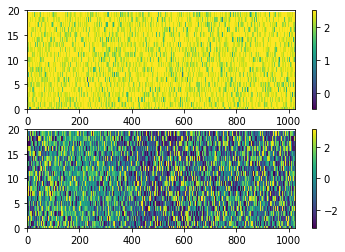

134


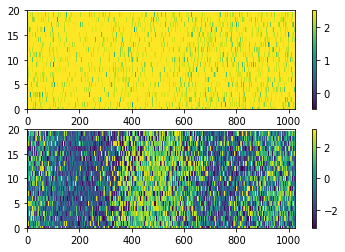

135


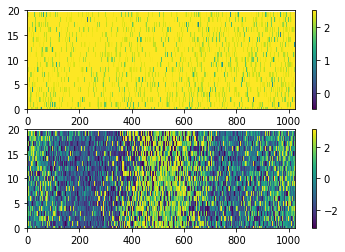

182


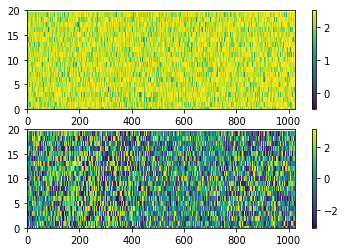

185


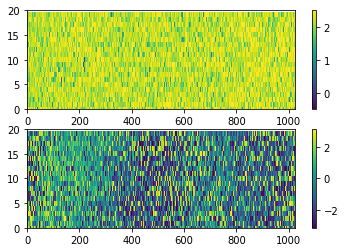

199


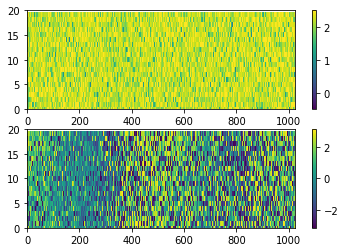

In [26]:

for i in faulty_predictions:
    print(i)
    plot_one_vis(dataset[i], 20)

Object `hera_sim.simulate` not found.
